<a href="https://colab.research.google.com/github/hieu0902/Nguyen-Dinh-Minh-Hieu_20210345_HW2_W11/blob/main/HW2_Week11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PART II: PROGRAMMING EXCERCISES**

# **1. Polynomial Regression**

**1.1. Implementing Polynomial Regression**

polyreg.py

In [ ]:
'''
    Template for polynomial regression
    AUTHOR Eric Eaton, Xiaoxiang Hu
'''

import numpy as np


#-----------------------------------------------------------------
#  Class PolynomialRegression
#-----------------------------------------------------------------

class PolynomialRegression:

    def __init__(self, degree = 1, regLambda = 1E-8):
        '''
        Constructor
        '''
        self.degree = degree
        self.regLambda = regLambda
        self.theta = None
        self.mean = None
        self.std = None


    def polyfeatures(self, X, degree):
        '''
        Expands the given X into an n * d array of polynomial features of
            degree d.

        Returns:
            A n-by-d numpy array, with each row comprising of
            X, X * X, X ** 3, ... up to the dth power of X.
            Note that the returned matrix will not inlude the zero-th power.

        Arguments:
            X is an n-by-1 column numpy array
            degree is a positive integer
        '''
        #TODO
        expandedArr = []
        for x in range(0, X.size):
            curArr = []
            for y in range(0, degree):
                curArr.append(X[x]**(1 + y))
            expandedArr.append(curArr)
        return expandedArr

    def fit(self, X, y):
        '''
            Trains the model
            Arguments:
                X is a n-by-1 array
                y is an n-by-1 array
            Returns:
                No return value
            Note:
                You need to apply polynomial expansion and scaling
                at first
        '''
        # convert X into a n * d array of polynomial features of
        # degree d
        XExpanded = self.polyfeatures(X, self.degree)

        XExpandedNP = np.array(XExpanded)

        # get std and mean for training data (to be used for testing as well)
        std = np.std(XExpandedNP, axis=0)
        mean = np.mean(XExpandedNP, axis=0)
        self.std = std
        self.mean = mean

        # standardize data
        XExpandedNP = (XExpandedNP - mean) / std

        # add the zero-th order feature row (i.e. x_0 = 1)
        XExpandedNP = np.c_[np.ones((XExpandedNP.shape[0],1)), XExpandedNP]

        # fit
        n,d = XExpandedNP.shape
        d = d - 1
        regMatrix = self.regLambda * np.eye(d + 1)
        regMatrix[0,0] = 0

        self.theta = np.linalg.pinv(XExpandedNP.T.dot(XExpandedNP) + regMatrix).dot(XExpandedNP.T).dot(y);

    def predict(self, X):
        '''
        Use the trained model to predict values for each instance in X
        Arguments:
            X is a n-by-1 numpy array
        Returns:
            an n-by-1 numpy array of the predictions
        '''
        XExpanded = self.polyfeatures(X, self.degree)
        XExpandedNP = np.array(XExpanded)

        # standardize data based on training means and stds
        XExpandedNP = (XExpandedNP - self.mean) / self.std

        # add the zero-th order feature row (i.e. x_0 = 1)
        XExpandedNP = np.c_[np.ones((XExpandedNP.shape[0],1)), XExpandedNP]

        return XExpandedNP.dot(self.theta)

#-----------------------------------------------------------------
#  End of Class PolynomialRegression
#-----------------------------------------------------------------



def learningCurve(Xtrain, Ytrain, Xtest, Ytest, regLambda, degree):
    '''
    Compute learning curve

    Arguments:
        Xtrain -- Training X, n-by-1 matrix
        Ytrain -- Training y, n-by-1 matrix
        Xtest -- Testing X, m-by-1 matrix
        Ytest -- Testing Y, m-by-1 matrix
        regLambda -- regularization factor
        degree -- polynomial degree

    Returns:
        errorTrain -- errorTrain[i] is the training accuracy using
        model trained by Xtrain[0:(i+1)]
        errorTest -- errorTrain[i] is the testing accuracy using
        model trained by Xtrain[0:(i+1)]

    Note:
        errorTrain[0:1] and errorTest[0:1] won't actually matter, since we start displaying the learning curve at n = 2 (or higher)
    '''

    n = len(Xtrain);

    errorTrain = np.zeros((n))
    errorTest = np.zeros((n))

    #TODO -- complete rest of method; errorTrain and errorTest are already the correct shape

    model = PolynomialRegression(degree = degree, regLambda = regLambda)

    i = 2
    while i < n:
        model.fit(Xtrain[0:i], Ytrain[0:i])
        predictions_train = model.predict(Xtrain[0:i])
        predictions_test = model.predict(Xtest)
        errorTrain[i] = 1.0/i  * sum((predictions_train - Ytrain[0:i]) ** 2)
        errorTest[i]  = 1.0/(len(Xtest)) * sum((predictions_test - Ytest) ** 2)
        i += 1

    return (errorTrain, errorTest)

**1.2. Examine the Bias-Variance Tradeoff through Learning Curves**

test_polyreg_learningCurve.py

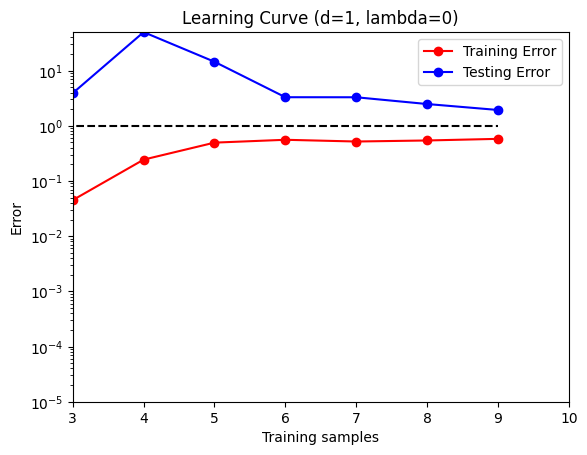

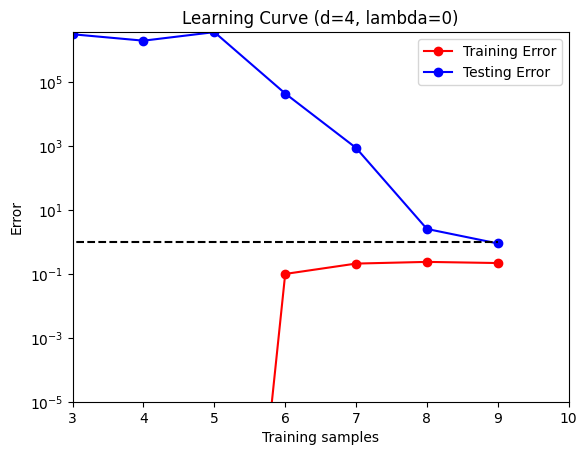

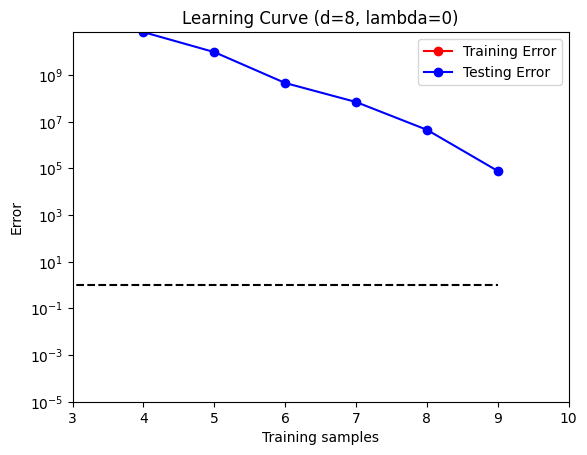

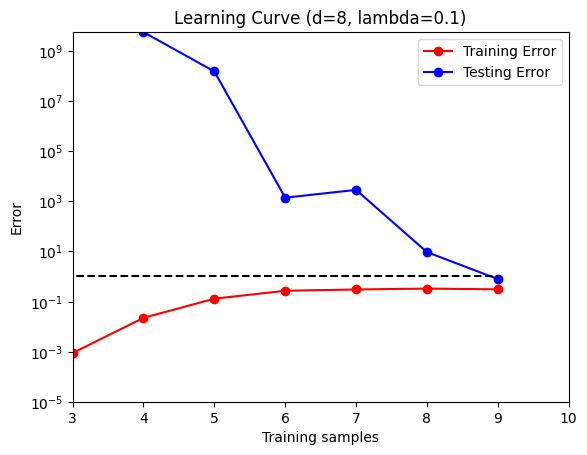

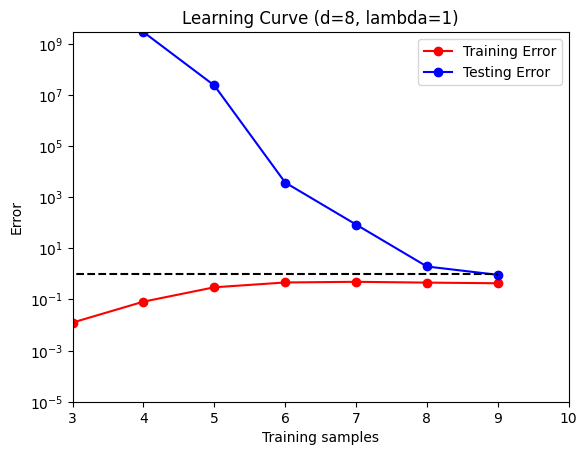

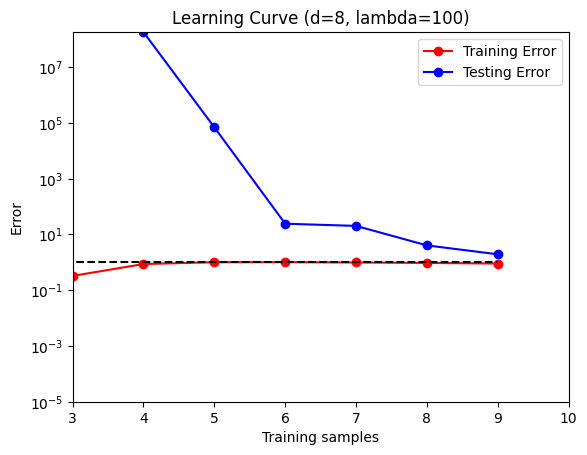

In [ ]:
'''
    TEST SCRIPT FOR POLYNOMIAL REGRESSION 1
    AUTHOR Eric Eaton, Xiaoxiang Hu
'''

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import LeaveOneOut






#----------------------------------------------------
# Plotting tools

def plotLearningCurve(errorTrain, errorTest, regLambda, degree):
    '''
        plot computed learning curve
    '''
    minX = 3
    maxY = max(errorTest[minX+1:])

    xs = np.arange(len(errorTrain))
    plt.plot(xs, errorTrain, 'r-o')

    plt.plot(xs, errorTest, 'b-o')
    plt.plot(xs, np.ones(len(xs)), 'k--')

    plt.legend(['Training Error', 'Testing Error'], loc = 'best')
    plt.title('Learning Curve (d='+str(degree)+', lambda='+str(regLambda)+')')
    plt.xlabel('Training samples')
    plt.ylabel('Error')
    plt.yscale('log')
    plt.ylim((1e-5,maxY))
    plt.xlim((minX,10))


def generateLearningCurve(X, y, degree, regLambda):
    '''
        computing learning curve via leave one out CV
    '''

    n = len(X);

    errorTrains = np.zeros((n, n-1));
    errorTests = np.zeros((n, n-1));

    loo = LeaveOneOut()
    itrial = 0
    for train_index, test_index in loo.split(X):
        #print("TRAIN indices:", train_index, "TEST indices:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        (errTrain, errTest) = learningCurve(X_train, y_train, X_test, y_test, regLambda, degree)

        errorTrains[itrial, :] = errTrain
        errorTests[itrial, :] = errTest
        itrial = itrial + 1

    errorTrain = errorTrains.mean(axis = 0)
    errorTest = errorTests.mean(axis = 0)

    plotLearningCurve(errorTrain, errorTest, regLambda, degree)




#-----------------------------------------------

if __name__ == "__main__":
    '''
        Main function to test polynomial regression
    '''

    # load the data
    filePath = "/content/polydata.dat"
    file = open(filePath,'r')
    allData = np.loadtxt(file, delimiter=',')

    X = allData[:, 0]
    y = allData[:, 1]

    # generate Learning curves for different params
    plt.subplots(1 , 1 )
    generateLearningCurve(X, y, 1, 0);
    plt.subplots(1, 1)
    generateLearningCurve(X, y, 4, 0);
    plt.subplots(1, 1)
    generateLearningCurve(X, y, 8, 0);
    plt.subplots(1, 1)
    generateLearningCurve(X, y, 8, .1);
    plt.subplots(1, 1)
    generateLearningCurve(X, y, 8, 1);
    plt.subplots(1, 1)
    generateLearningCurve(X, y, 8, 100);
    plt.show()

# **2. Logistic Regression**

**2.1. Implementation**

logreg.py

In [ ]:
'''
    TEMPLATE FOR MACHINE LEARNING HOMEWORK
    AUTHOR Eric Eaton
'''

import numpy as np

class LogisticRegression:

    def __init__(self, alpha = 0.01, regLambda=0.01, epsilon=0.0001, maxNumIters = 10000):
        '''
        Constructor
        '''
        self.alpha = alpha
        self.regLambda = regLambda
        self.epsilon = epsilon
        self.maxNumIters = maxNumIters
        self.theta = None

    def computeCost(self, theta, X, y, regLambda):
        '''
        Computes the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-dimensional numpy vector
            regLambda is the scalar regularization constant
        Returns:
            a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
        '''
        n,d = X.shape
        cost = (-y.T * np.log(self.sigmoid(X * theta)) - (1.0 - y).T *
            np.log(1.0 - self.sigmoid(X * theta)))/n + regLambda/(2.0 * n) * (theta.T * theta)
        return cost.item((0,0))

    def computeGradient(self, theta, X, y, regLambda):
        '''
        Computes the gradient of the objective function
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-dimensional numpy vector
            regLambda is the scalar regularization constant
        Returns:
            the gradient, an d-dimensional vector
        '''
        n, d = X.shape
        gradient = (X.T * (self.sigmoid(X * theta) - y) + regLambda*theta) / n
        # l,f = theta.shape
        # print "n = %d" % (n)
        # print "d = %d" % (d)
        # print "l = %d" % (l)
        # print "f = %d" % (f)

        # don't regularize the theta_0 parameter
        gradient[0] = sum(self.sigmoid(X * theta) - y) / n
        return gradient

    def fit(self, X, y):
        '''
        Trains the model
        Arguments:
            X is a n-by-d numpy matrix
            y is an n-dimensional numpy vector
        '''

        a,b = X.shape
        # add the 1's features
        X = np.c_[np.ones((a,1)), X]

        # create a random starting theta
        self.theta = np.mat(np.random.rand(b + 1,1))

        theta_old = self.theta
        theta_new = self.theta

        i = 0
        while i < self.maxNumIters:
            theta_new = theta_old - self.alpha * self.computeGradient(theta_new, X, y, self.regLambda)
            if self.hasConverged(theta_new, theta_old):
                self.theta = theta_new
                return
            else:
                theta_old = np.copy(theta_new)
                i = i + 1
                cost = self.computeCost(theta_new, X, y, self.regLambda)
                # print "cost: ", cost

        self.theta = theta_new

    def hasConverged(self, theta_new, theta_old):
        if np.linalg.norm(theta_new - theta_old) < self.epsilon:
            return True
        else:
            return False


    def predict(self, X):
        '''
        Used the model to predict values for each instance in X
        Arguments:
            X is a n-by-d numpy matrix
        Returns:
            an n-dimensional numpy vector of the predictions
        '''
        a,b = X.shape
        # add the 1's features
        X = np.c_[np.ones((a,1)), X]
        # use the sigmoid method to predict the values for X
        return np.array(self.sigmoid(X * self.theta))

    def sigmoid(self, z):
        '''
        This method wasn't provided in the hw template...
        Computes sigmoid for both vectors and matrices
        '''

        # test to verify this works for matrices AND vectors
        # test_z_matrix = np.matrix('1 2; 3 4')
        # test_z_vector = np.array([2,3,1,0])
        # test1 = 1.0 / (1.0 + np.exp(-test_z_vector))
        # test2 = 1.0 / (1.0 + np.exp(-test_z_matrix))
        # print test1
        # print test2

        return 1.0 / (1.0 + np.exp(-z))

**2.2. Testing your Implementation**

test_logreg1.py

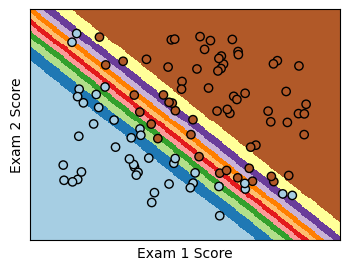

In [ ]:
# Test script for training a logistic regressiom model
#
# Author: Eric Eaton
#
# This file should run successfully without changes if your implementation is correct
#
from numpy import loadtxt, ones, zeros, where
import numpy as np
from pylab import plot,legend,show,where,scatter,xlabel, ylabel,linspace,contour,title
import matplotlib.pyplot as plt


if __name__ == "__main__":
    # Load Data
    filename = '/content/data1.dat'
    data = loadtxt(filename, delimiter=',')
    X = data[:, 0:2]
    y = np.array([data[:, 2]]).T
    n,d = X.shape

    # Standardize the data
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    X = (X - mean) / std

    # train logistic regression
    logregModel = LogisticRegression(regLambda = 0.00000001)
    logregModel.fit(X,y)

    # Plot the decision boundary
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = logregModel.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)

    # Configure the plot display
    plt.xlabel('Exam 1 Score')
    plt.ylabel('Exam 2 Score')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()